___
![](resource/dl_workflow.png)

#### Next Implementation
- Deep Learning Algorithm :
    - Convolution Neural Network
- Model Task :
    - Detection (Face Detection)
    - Feature Extraction 
    - Classification 

## 0. Import Library

In [1]:
import os
import cv2
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Input

from tensorflow.keras.utils import to_categorical


# 1. Face Recognition using (Convolution Neural Network) CNN

In [4]:
from keras.layers import Conv2D, MaxPool2D, Flatten

#### Convolution Layer

- `keras.layers.Conv2d(filter, kernel_size, strides, padding, activation)`
> 2D convolution layer (e.g. spatial convolution over images).\
> This layer creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs.
- parameter :
    - `filter` : Integer, the dimensionality of the output space.
    - `kernel_size` : kernel_size: An integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window.
    - `strides` : An integer or tuple/list of 2 integers, specifying the strides of the convolution along the height and width.
    - `padding` : one of `"valid"` or `"same"` (case-insensitive)
    - `activation` : Activation function to use. (`relu`, `sigmoid`, `softmax`, `linear`, .etc)

#### Max Pooling Layer

- `keras.layers.MaxPool2D(pool_size, strides, padding)`
> 2D Max pooling operation for spatial data.
- parameter :
    - `pool_size` : integer or tuple of 2 integers, factors by which to downscale.
    - `strides` : An integer or tuple/list of 2 integers, specifying the strides of the convolution along the height and width.
    - `padding` : one of `"valid"` or `"same"` (case-insensitive)

#### Flatten Layer


- `keras.layers.Flatten()`
> Flattens the input data to 1D tensor.
- parameter :
    - N/A

## 1.1 read image & convert to grayscale

- Download Dataset : 
    - **LFW - images aligned with deep funneling** : https://www.kaggle.com/jessicali9530/lfw-dataset?select=matchpairsDevTrain.csv
    
    
- Dataset Structure :

```
dataset\
    label_name_A\
        label_name_A_001.jpg
        label_name_A_002.jpg
        label_name_A_003.jpg
        .
        .
    label_name_B\
        label_name_B_001.jpg
        label_name_B_002.jpg
        label_name_B_003.jpg
        .
        .
```

In [5]:
# Load the cascade
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_default.xml')

In [6]:
def print_progress(val, val_len, folder, bar_size=20):
    progr = "#"*round((val)*bar_size/val_len) + " "*round((val_len - (val))*bar_size/val_len)
    if val == 0:
        print("", end = "\n")
    else:
        print("[%s] (%d samples)\t label : %s \t\t" % (progr, val+1, folder), end="\r")

In [11]:
dataset_folder = "dataset/"

names = []
images = []
for folder in os.listdir(dataset_folder):
    files = os.listdir(os.path.join(dataset_folder, folder))[:150]
    if len(files) < 50 :
        continue
    for i, name in enumerate(files): 
        if name.find(".jpg") > -1 :
            img = cv2.imread(os.path.join(dataset_folder + folder, name))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(img, 1.1, 5)
            for (x, y, w, h) in faces:
                face_img = img[y:y+h, x:x+w]
                face_img = cv2.resize(face_img, (50, 50))
                images.append(face_img)
                names.append(folder)

                print_progress(i, len(files), folder)


[####################] (77 samples)	 label : Ariel_Sharon 		

[####################] (150 samples)	 label : Colin_Powell 		
[####################] (121 samples)	 label : Donald_Rumsfeld 		
[####################] (150 samples)	 label : George_W_Bush 		
[####################] (109 samples)	 label : Gerhard_Schroeder 		
[####################] (71 samples)	 label : Hugo_Chavez 		
[####################] (52 samples)	 label : Jacques_Chirac 		
[####################] (55 samples)	 label : Jean_Chretien 		
[####################] (53 samples)	 label : John_Ashcroft 		
[####################] (60 samples)	 label : Junichiro_Koizumi 		
[################### ] (97 samples)	 label : Manh Hung 		
[####################] (52 samples)	 label : Serena_Williams 		


In [12]:
print("number of samples :", len(names))

number of samples : 1258


### 1.1.A Image Augmentation
- To solve problem with small dataset on some class, we can augmenting the data to increase number of sample.
- Image augmentation is a set of transfomration like translation, rotation, grayscale color adjust, etc. 

In [13]:
def img_augmentation(img):
    h, w = img.shape
    center = (w // 2, h // 2)
    M_rot_5 = cv2.getRotationMatrix2D(center, 5, 1.0)
    M_rot_neg_5 = cv2.getRotationMatrix2D(center, -5, 1.0)
    M_rot_10 = cv2.getRotationMatrix2D(center, 10, 1.0)
    M_rot_neg_10 = cv2.getRotationMatrix2D(center, -10, 1.0)
    M_trans_3 = np.float32([[1, 0, 3], [0, 1, 0]])
    M_trans_neg_3 = np.float32([[1, 0, -3], [0, 1, 0]])
    M_trans_6 = np.float32([[1, 0, 6], [0, 1, 0]])
    M_trans_neg_6 = np.float32([[1, 0, -6], [0, 1, 0]])
    M_trans_y3 = np.float32([[1, 0, 0], [0, 1, 3]])
    M_trans_neg_y3 = np.float32([[1, 0, 0], [0, 1, -3]])
    M_trans_y6 = np.float32([[1, 0, 0], [0, 1, 6]])
    M_trans_neg_y6 = np.float32([[1, 0, 0], [0, 1, -6]])
    
    imgs = []
    imgs.append(cv2.warpAffine(img, M_rot_5, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_rot_neg_5, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_rot_10, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_rot_neg_10, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_3, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_3, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_6, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_6, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_y3, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_y3, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_y6, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_y6, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.add(img, 10))
    imgs.append(cv2.add(img, 30))
    imgs.append(cv2.add(img, -10))
    imgs.append(cv2.add(img, -30)) 
    imgs.append(cv2.add(img, 15))
    imgs.append(cv2.add(img, 45))
    imgs.append(cv2.add(img, -15))
    imgs.append(cv2.add(img, -45))
    
    return imgs

- test augmentation result

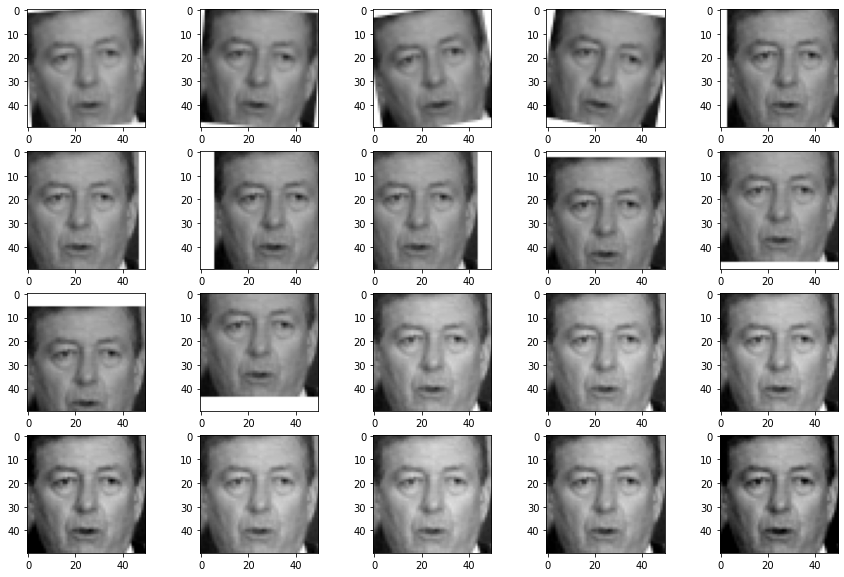

In [15]:
img_test = images[890]

augmented_image_test = img_augmentation(img_test)

plt.figure(figsize=(15,10))
for i, img in enumerate(augmented_image_test):
    plt.subplot(4,5,i+1)
    plt.imshow(img, cmap="gray")
plt.show()

- apply augmentation to all images

In [17]:
augmented_images = []
augmented_names = []
for i, img in enumerate(images):
    try :
        augmented_images.extend(img_augmentation(img))
        augmented_names.extend([names[i]] * 20)
    except :
        print(i)
images.extend(augmented_images)
names.extend(augmented_names)

- total augmentation image

In [18]:
len(augmented_images), len(augmented_names)

(25160, 25160)

- total images augmentation + original

In [19]:
len(images), len(names)

(26418, 26418)

In [20]:
unique, counts = np.unique(names, return_counts = True)

for item in zip(unique, counts):
    print(item)

('Ariel_Sharon', 1722)
('Colin_Powell', 3423)
('Donald_Rumsfeld', 2814)
('George_W_Bush', 3507)
('Gerhard_Schroeder', 2310)
('Hugo_Chavez', 1638)
('Jacques_Chirac', 1113)
('Jean_Chretien', 1239)
('John_Ashcroft', 1260)
('Junichiro_Koizumi', 1470)
('Manh Hung', 1680)
('Serena_Williams', 1092)
('Tony_Blair', 3150)


### 1.1.B Balancing Data

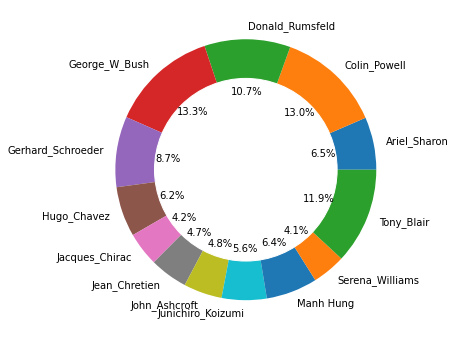

In [21]:
# preview data distribution

def print_data(label_distr, label_name):
    plt.figure(figsize=(12,6))

    my_circle = plt.Circle( (0,0), 0.7, color='white')
    plt.pie(label_distr, labels=label_name, autopct='%1.1f%%')
    plt.gcf().gca().add_artist(my_circle)
    plt.show()
    
unique = np.unique(names)
label_distr = {i:names.count(i) for i in names}.values()
print_data(label_distr, unique)

In [22]:
# reduce sample size per-class using numpy random choice
n = 1000

def randc(labels, l):
    return np.random.choice(np.where(np.array(labels) == l)[0], n, replace=False)

mask = np.hstack([randc(names, l) for l in np.unique(names)])

In [23]:
names = [names[m] for m in mask]
images = [images[m] for m in mask]

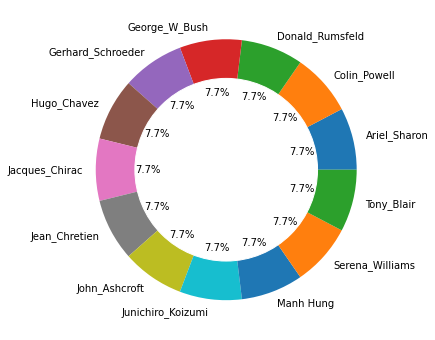

In [24]:
label_distr = {i:names.count(i) for i in names}.values()
print_data(label_distr, unique)

### 1.2 Encoding Label & Categoricalization

![](resource/encoding.png)

In [25]:
le = LabelEncoder()

le.fit(names)

labels = le.classes_

name_vec = le.transform(names)

categorical_name_vec = to_categorical(name_vec)

In [26]:
print("number of class :", len(labels))
print(labels)

number of class : 13
['Ariel_Sharon' 'Colin_Powell' 'Donald_Rumsfeld' 'George_W_Bush'
 'Gerhard_Schroeder' 'Hugo_Chavez' 'Jacques_Chirac' 'Jean_Chretien'
 'John_Ashcroft' 'Junichiro_Koizumi' 'Manh Hung' 'Serena_Williams'
 'Tony_Blair']


In [27]:
print(name_vec)

[ 0  0  0 ... 12 12 12]


In [28]:
print(categorical_name_vec)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


### 1.3 Split Dataset

In [33]:
x_train, x_test, y_train, y_test = train_test_split(np.array(images, dtype=np.float32),   # input data
                                                    np.array(categorical_name_vec),       # target/output data 
                                                    test_size=0.2, 
                                                    random_state=42)

In [34]:
print(x_train.shape, y_train.shape, x_test.shape,  y_test.shape)

(10400, 50, 50) (10400, 13) (2600, 50, 50) (2600, 13)


### 1.4 Reshape Data

In [35]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

In [36]:
x_train.shape, x_test.shape

((10400, 50, 50, 1), (2600, 50, 50, 1))

### 1.5 Create CNN Model

In [37]:
def cnn_model(input_shape):  
    model = Sequential()
    
    model.add(Conv2D(64,
                    (3,3),
                    padding="valid",
                    activation="relu",
                    input_shape=input_shape))
    model.add(Conv2D(64,
                    (3,3),
                    padding="valid",
                    activation="relu",
                    input_shape=input_shape))
    
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    model.add(Conv2D(128,
                    (3,3),
                    padding="valid",
                    activation="relu"))
    model.add(Conv2D(128,
                    (3,3),
                    padding="valid",
                    activation="relu"))
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    
    model.add(Dense(128, activation="relu"))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(len(labels)))  # equal to number of classes
    model.add(Activation("softmax"))
    
    model.summary() 
    
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy',
                  metrics = ['accuracy'])

    return model

### 1.6 Training CNN Model

In [39]:
input_shape = x_train[0].shape

EPOCHS = 10
BATCH_SIZE = 32

model = cnn_model(input_shape)

history = model.fit(x_train, 
                    y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    validation_split=0.15   # 15% of train dataset will be used as validation set
                    )

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 conv2d_5 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 21, 21, 128)       73856     
                                                                 
 conv2d_7 (Conv2D)           (None, 19, 19, 128)       147584    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 9, 9, 128)        0         
 2D)                                                  

- run training with `EPOCHS` and `BATCH_SIZE` set.
- `BATCH_SIZE` is the number of samples to be propagated into the Network
- Benefit of using `BATCH_SIZE` < training sample
     - less memory to consume: because it uses less data when processed in the network
     - the network makes the learning process faster
- Using `BATCH_SIZE` too small may result in fluctuating gradient updates
- 1 `EPOCH` means 1 forwardpass and backwardpass for the whole training sample
- Number of `ITERATIONS` number of forwardpass and backwardpass for each `BATCH_SIZE`
- Example :
    - we have 1000 training samples
    - we select `BATCH_SIZE` 10 and `EPOCH` 5
    - so that in each `EPOCH` forwardpass and backwardpass will be carried out for 1000 training samples which are divided into 10 batches, where each batch will be processed 100 samples.
    - This process will produce at least 100x5 iterations (forwardpass and backwardpass).

### 1.7 Evaluation
- Plot history accuracy, precision and recall for training set and validation set

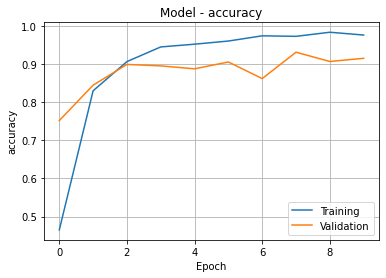

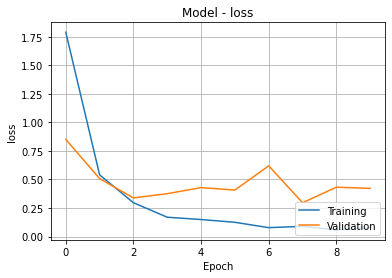

In [40]:
def evaluate_model_(history):
    names = [['accuracy', 'val_accuracy'], 
             ['loss', 'val_loss']]
    for name in names :
        fig1, ax_acc = plt.subplots()
        plt.plot(history.history[name[0]])
        plt.plot(history.history[name[1]])
        plt.xlabel('Epoch')
        plt.ylabel(name[0])
        plt.title('Model - ' + name[0])
        plt.legend(['Training', 'Validation'], loc='lower right')
        plt.grid()
        plt.show()
        
evaluate_model_(history)

- the plot accuracy for data validation looks more **fluctuating**, is this normal?
- this can be caused by `BATCH_SIZE` which is **too small**, for example if the dataset contains misslabeled data which causes the loss value to increase or move it away from the local minima.
- this effect can be avoided if we choose a larger `BATCH_SIZE`.
- However, `BATCH_SIZE` which is **too large** can cause the **training** process to be heavier and **slow**.
- otherwise `BATCH_SIZE` **too large** will result in **generalization** on the model to be **bad** (source [link](https://medium.com/mini-distill/effect-of-batch -size-on-training-dynamics-21c14f7a716e#:~:text=large%20batch%20size%20means%20the,all%20about%20the%20same%20size.))
- **Generalization** is one of the capabilities of the Neural Network, which means the model is able to classify data that has never been seen before (*unseen data*) (source [link](http://www.eie.polyu.edu.hk/~ enzheru/snns/SNNSinfo/UserManual/node16.html#:~:text=Learning%20in%20Neural-,Generalization%20of%20Neural%20Networks,it%20has%20never%20seen%20before.))

- save model

In [41]:
model.save("model-cnn-facerecognition.h5")

- predict to all test dataset

In [42]:
# predict test data
y_pred=model.predict(x_test)

- plot confusion matrix

In [43]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 8))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

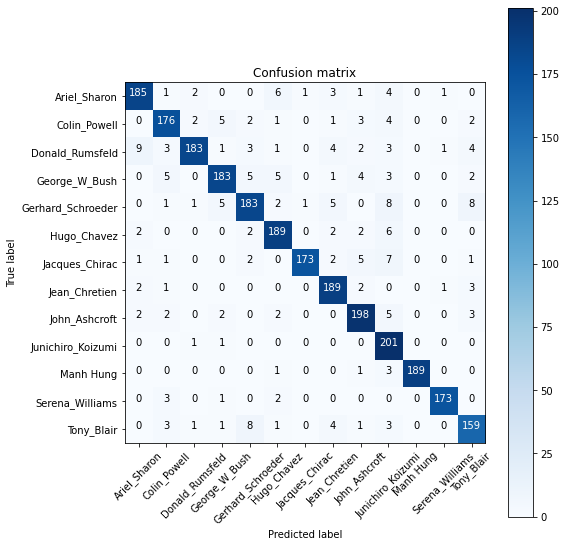

In [44]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=labels,normalize=False,
                      title='Confusion matrix')


- Calculate metric report using `classification_report()` provided by `scikit-learn` 

In [35]:
print(classification_report(y_test.argmax(axis=1), 
                            y_pred.argmax(axis=1), 
                            target_names=labels))

                   precision    recall  f1-score   support

     Ariel_Sharon       0.90      0.95      0.93       158
     Colin_Powell       0.93      0.91      0.92       164
  Donald_Rumsfeld       0.91      0.92      0.91       154
    George_W_Bush       0.83      0.87      0.85       134
Gerhard_Schroeder       0.90      0.89      0.90       141
      Hugo_Chavez       0.91      0.90      0.90       148
    John_Ashcroft       0.98      0.88      0.93       148
        Manh Hung       0.97      1.00      0.99       153

         accuracy                           0.92      1200
        macro avg       0.92      0.92      0.92      1200
     weighted avg       0.92      0.92      0.92      1200



___

# Apply Our Face Dataset

- create new class data from yout face, the below is to delete file

In [9]:
import shutil
def delete_folder(folder_name):
    shutil.rmtree(dataset_folder + folder_name)

In [10]:
cap = cv2.VideoCapture(0)

my_name = "Manh Hung"
delete_folder(my_name)
os.mkdir(dataset_folder + my_name)
num_sample = 100

i = 0
while cap.isOpened():
    ret, frame = cap.read()
    
    if ret :
        cv2.imshow("Capture Photo", frame)
        cv2.imwrite("dataset/%s/%s_%04d.jpg" %  (my_name, my_name, i), cv2.resize(frame, (250,250)))
        
        if cv2.waitKey(100) == ord('q') or i == num_sample:
            break
        i += 1    
cap.release()
cv2.destroyAllWindows()

- Rerun Load dataset, Traing & Test Model

___
## Face_recognition on Video Frame

In [45]:
from keras.models import load_model

In [46]:
def draw_ped(img, label, x0, y0, xt, yt, color=(255,127,0), text_color=(255,255,255)):

    (w, h), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    cv2.rectangle(img,
                  (x0, y0 + baseline),  
                  (max(xt, x0 + w), yt), 
                  color, 
                  2)
    cv2.rectangle(img,
                  (x0, y0 - h),  
                  (x0 + w, y0 + baseline), 
                  color, 
                  -1)  
    cv2.putText(img, 
                label, 
                (x0, y0),                   
                cv2.FONT_HERSHEY_SIMPLEX,     
                0.5,                          
                text_color,                
                1,
                cv2.LINE_AA) 
    return img

In [47]:
# --------- load Haar Cascade model -------------
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_default.xml')

# --------- load Keras CNN model -------------
model = load_model("model-cnn-facerecognition.h5")
print("[INFO] finish load model...")

cap = cv2.VideoCapture(0)
while cap.isOpened() :
    ret, frame = cap.read()
    if ret:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.1, 5)
        for (x, y, w, h) in faces:
            
            face_img = gray[y:y+h, x:x+w]
            face_img = cv2.resize(face_img, (50, 50))
            face_img = face_img.reshape(1, 50, 50, 1)
            
            result = model.predict(face_img)
            idx = result.argmax(axis=1)
            confidence = result.max(axis=1)*100
            if confidence > 85:
                label_text = "%s (%.2f %%)" % (labels[idx], confidence)
            else :
                label_text = "N/A"
            frame = draw_ped(frame, label_text, x, y, x + w, y + h, color=(0,255,255), text_color=(50,50,50))
       
        cv2.imshow('Detect Face', frame)
    else :
        break
    if cv2.waitKey(10) == ord('q'):
        break
        
cv2.destroyAllWindows()
cap.release()

[INFO] finish load model...
